In [23]:
import pandas as pd
import numpy as np
import joblib as jb
import tifffile
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import cv2
from scipy import stats

In [2]:
df_data = jb.load('../data/generated_baseline/bands_cspm/val_data_bands_cspm_baseline_low_var_filter.pkl.z')
df_data.head(3)

,b1,b5,b6,cspmb7,z,x,y,rf_pred,lgbm_pred
0,0.1199,0.0490,0.0316,23.382784,3.195862,233,1130,3.222788,3.253044
3,0.1199,0.0488,0.0324,23.158824,3.268182,233,1133,3.306878,3.277826
5,0.1196,0.0489,0.0323,23.607309,3.294375,233,1135,3.206168,3.640472


In [3]:
df_data.describe()

,b1,b5,b6,cspmb7,z,x,y,rf_pred,lgbm_pred
count,5477.000000,5477.00000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000,5477.000000
mean,0.122784,0.04054,0.026598,19.939545,7.060109,1130.150447,656.873288,7.080642,7.061393
std,0.003249,0.00749,0.004407,5.383045,4.460813,467.592993,403.898085,3.965421,3.494092
min,0.115700,0.02680,0.019100,12.179365,1.176939,233.000000,1.000000,1.602951,1.696409
25%,0.120300,0.03500,0.023800,16.614589,3.452857,779.000000,349.000000,3.967043,4.479635
50%,0.122800,0.03910,0.025700,18.696860,6.060000,1017.000000,619.000000,6.140881,6.090620
75%,0.125200,0.04460,0.028000,21.387827,9.566000,1495.000000,943.000000,9.106335,8.444198
max,0.135300,0.07420,0.069900,78.676675,25.792759,2295.000000,1637.000000,25.006943,21.313179


In [4]:
height = df_data.y.max() - df_data.y.min()
height

1636

In [5]:
width = df_data.x.max() - df_data.x.min()
width

2062

In [6]:
image = np.zeros((df_data.y.max()+1,df_data.x.max()+1))

In [7]:
image.shape

(1638, 2296)

In [8]:
for i, row in enumerate(df_data.itertuples()):
    x = row[-4]
    y = row[-3]
    rf_pred = row[-2]
    image[y][x] = rf_pred

In [9]:
image.max()

25.006942881097526

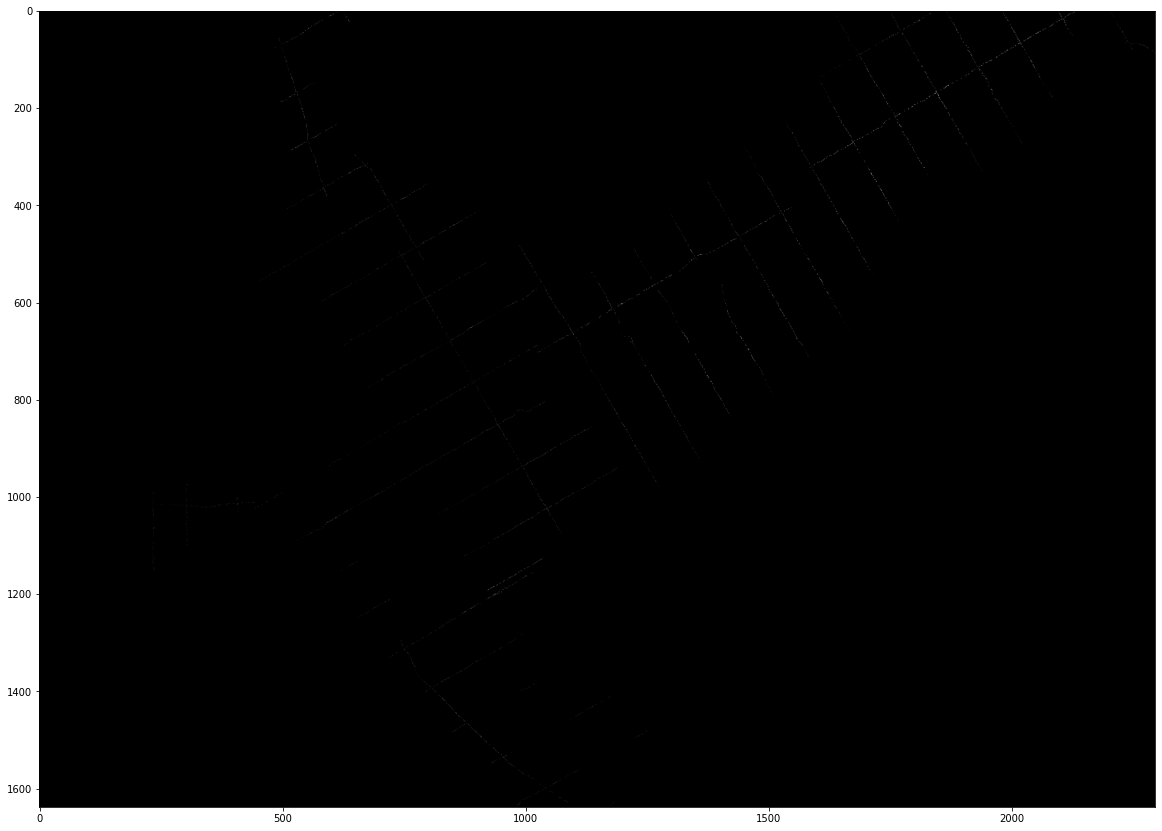

In [10]:
plt.figure(figsize=(20,15))
plt.imshow(image*100,'gray')

In [11]:
def convolution(image,kernel):
    result = image.copy()
    for y in range(int(kernel.shape[0]/2),image.shape[0]-int(kernel.shape[0]/2)):
        for x in range(int(kernel.shape[1]/2),image.shape[1]-int(kernel.shape[1]/2)):
            if(image[y][x] != 0):
                s = 0
                c = 0
                for i in range(kernel.shape[0]):
                    for j in range(kernel.shape[1]):
                        v = image[y+i-int(kernel.shape[0]/2)][x+j-int(kernel.shape[1]/2)] * kernel[i][j]
                        if(v != 0):
                            s += v
                            c += kernel[i][j]
                if(c!=0):
                    result[y][x] = s/float(c)
    return result

In [12]:
#r2 = 0.57
#kernel = np.array([[0.25,0.5,1,0.5,0.25],
#                   [0.5,1,1.5,1,0.5],
#                   [1,1.5,1.5,1.5,1],
#                   [0.5,1,1.5,1,0.5],
#                   [0.25,0.5,1,0.5,0.25]])

#r2 = 0.77
#kernel = np.array([[0.5,0.75,1,0.75,0.5],
#                   [0.75,1,1,1,0.75],
#                   [1,1,1,1,1],
#                   [0.75,1,1,1,0.75],
#                   [0.5,0.75,1,0.75,0.5]])

#r2 = 0.82
#kernel = np.array([[1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1]])


#r2 = 0.817
#kernel = np.ones((4,4))


#r2 = 0.826
#kernel = np.ones((6,6))

#r2 = 0.833
#kernel = np.ones((8,8))

#r2 = 0.836
#kernel = np.ones((10,10))

kernel = np.ones((15,15))

#r2 = 0.838
#kernel = np.ones((20,20))



#r2 = 0.832
#kernel = np.ones((25,25))

#r2 = 0.825
#kernel = np.ones((30,30))

#r2 = 0.809
#kernel = np.ones((40,40))



image_copy = convolution(image,kernel)

In [13]:
kernel

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.

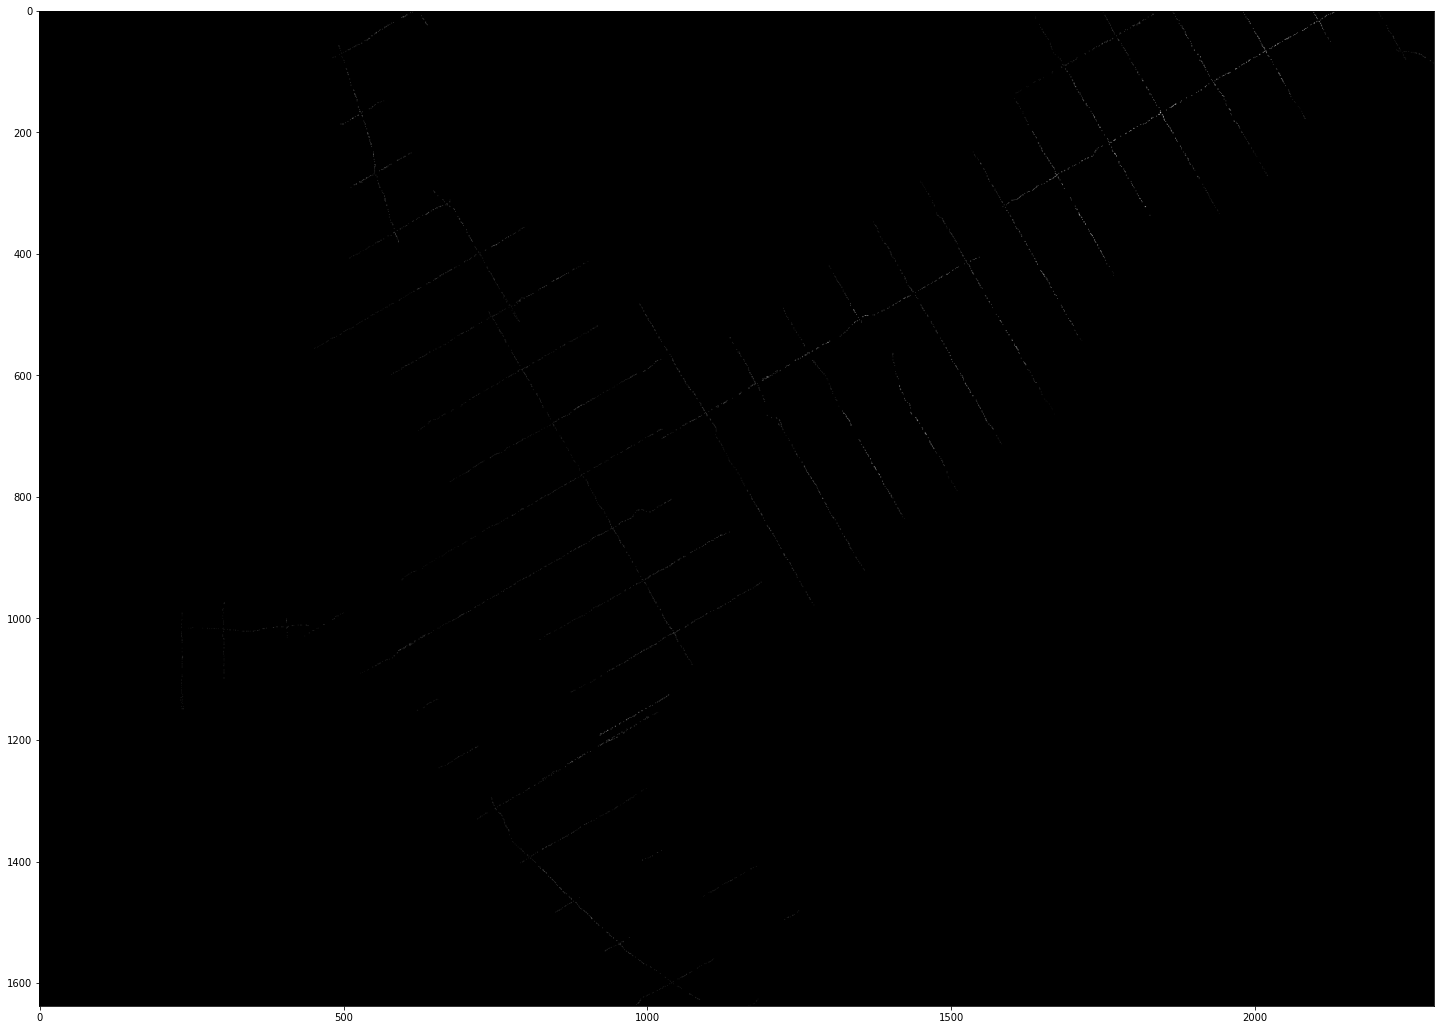

In [14]:
plt.figure(figsize=(25,20))
plt.imshow(image_copy*100,'gray')

In [15]:
new_df = pd.DataFrame(index=df_data.index)

In [16]:
df_data_copy = df_data.copy()
new_col = list()
for i, row in enumerate(df_data.itertuples()):
    x = row[-4]
    y = row[-3]
    new_col.append(image_copy[y][x])
df_data_copy['rf_pred_smooth'] = new_col

In [17]:
df_data_copy

,b1,b5,b6,cspmb7,z,x,y,rf_pred,lgbm_pred,rf_pred_smooth
0,0.1199,0.0490,0.0316,23.382784,3.195862,233,1130,3.222788,3.253044,3.186103
3,0.1199,0.0488,0.0324,23.158824,3.268182,233,1133,3.306878,3.277826,3.241882
5,0.1196,0.0489,0.0323,23.607309,3.294375,233,1135,3.206168,3.640472,3.241882
8,0.1224,0.0554,0.0345,28.922021,2.230000,234,1003,2.542534,3.519446,2.632087
14,0.1223,0.0535,0.0338,27.742739,2.258305,234,1009,2.878162,4.184618,2.708872
...,...,...,...,...,...,...,...,...,...,...
19262,0.1278,0.0474,0.0288,22.935431,4.471071,2281,78,7.281293,5.725309,6.354718
19275,0.1256,0.0438,0.0280,21.717054,3.169375,2289,83,3.969376,7.240660,3.969376
19276,0.1256,0.0436,0.0275,20.408150,3.026562,2290,83,8.460267,8.530231,8.460267
19283,0.1267,0.0482,0.0295,23.945153,1.909714,2294,86,3.069145,5.053403,3.069145


In [25]:
print('R2 score:', r2_score(df_data_copy['z'],df_data_copy['rf_pred_smooth']))
print('MAE:', mean_absolute_error(df_data_copy['z'], df_data_copy['rf_pred_smooth']))
print('MSE:', mean_squared_error(df_data_copy['z'], df_data_copy['rf_pred_smooth']))
print('RMSE:', np.sqrt(mean_squared_error(df_data_copy['z'], df_data_copy['rf_pred_smooth'])))

R2 score: 0.9064197286155776
MAE: 0.9485488184638247
MSE: 1.861799902197796
RMSE: 1.3644778862985636


Before convolution:  
RF Bands and CSPM Metrics:  
R2 score: 0.863064543200631  
MAE: 0.9804754169935506  
MSE: 2.7243607686193885  
RMSE: 1.6505637729634648  

In [19]:
r2_score(df_data_copy['z'],df_data_copy['rf_pred'])

0.8628787893588641

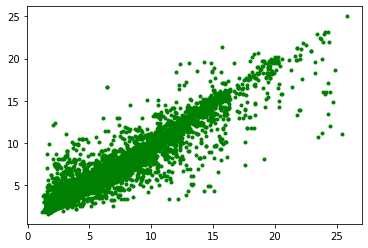

In [28]:
plt.plot(df_data_copy['z'],df_data_copy['rf_pred'],'g.')

In [29]:
jb.dump(df_data_copy,'../data/generated_baseline/convolution_cspm/val_data_bands_cspm_baseline_convolution_low_var.pkl.z')

['../data/generated_baseline/convolution_cspm/val_data_bands_cspm_baseline_convolution_low_var.pkl.z']